/home/lincy/.local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


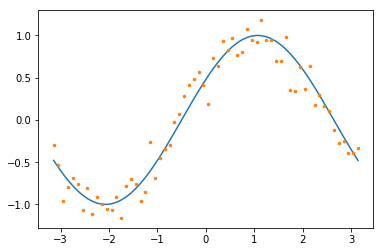

In [1]:
###
###  Non-linear fitting, 
###
###  1) batch_normaliozation
###  2) regulization
###  

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

N=64

### prepare data
# training set
P=0.5
x_train = np.linspace(-np.pi, np.pi,N).reshape(N,1)
y_exact = np.sin(x_train+P)
y_train = y_exact + np.random.normal(0, .2, size=y_exact.shape)

# testing set
x_test = np.sort(np.random.uniform(-np.pi, np.pi, N)).reshape(N,1)
y_test = np.sin(x_test+P)

# plot data
plt.plot(x_train, y_exact)
plt.plot(x_train, y_train, '.', markersize=5)
plt.show()

Tensor("Placeholder:0", shape=(64, 1), dtype=float32)
Tensor("dense_6/BiasAdd:0", shape=(64, 1), dtype=float32)


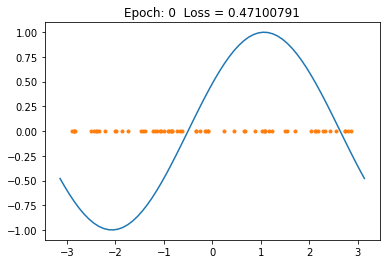

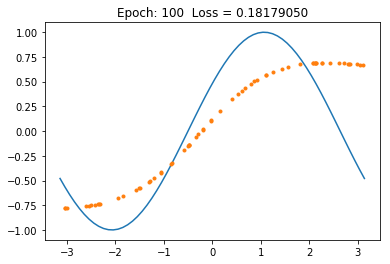

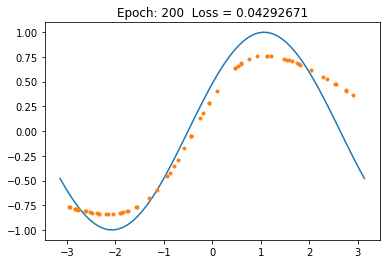

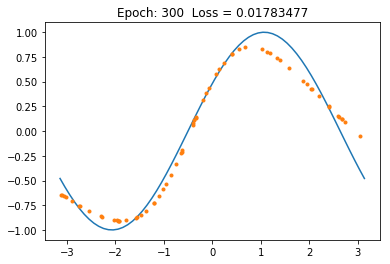

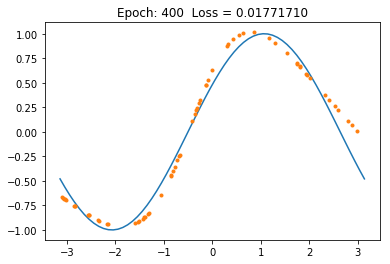

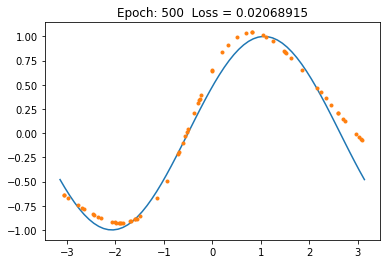

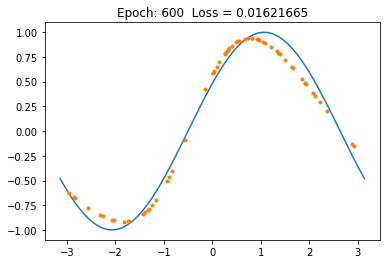

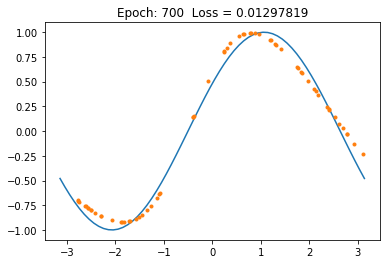

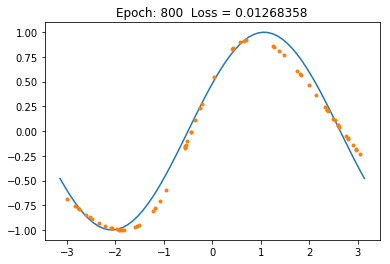

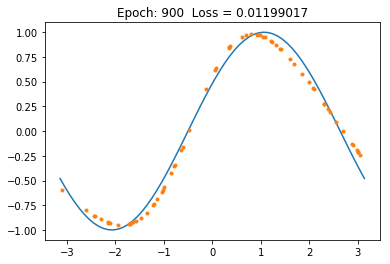

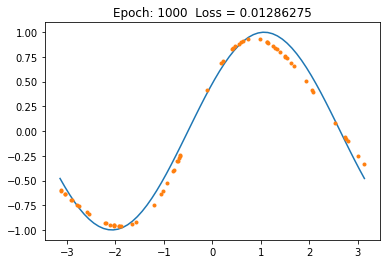

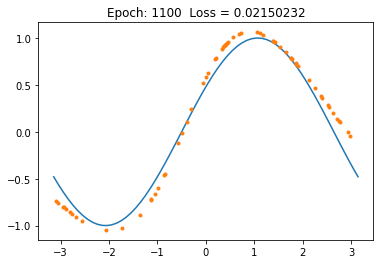

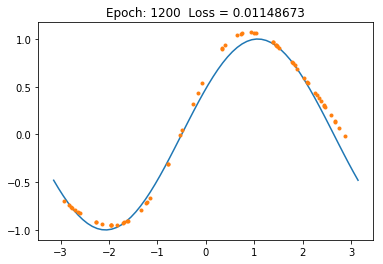

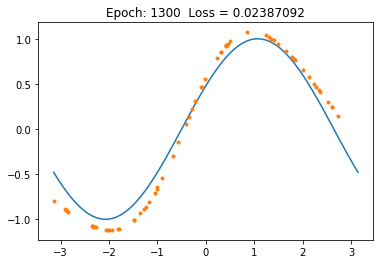

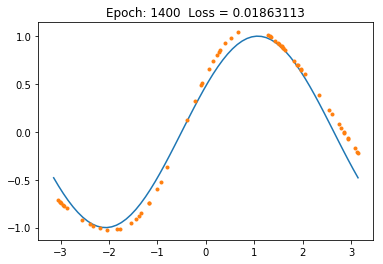

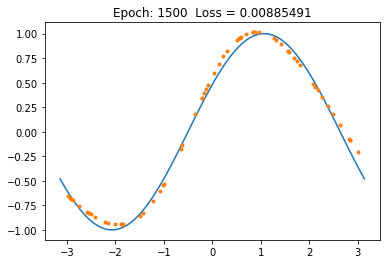

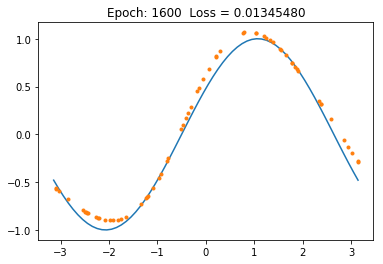

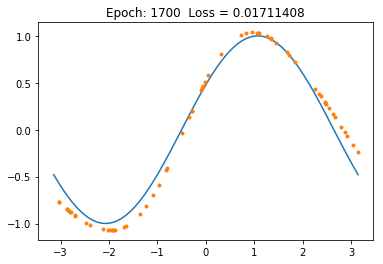

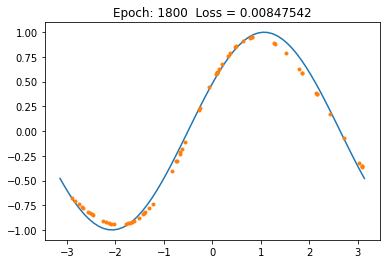

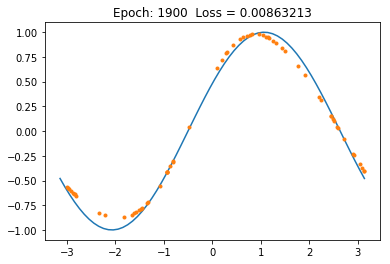

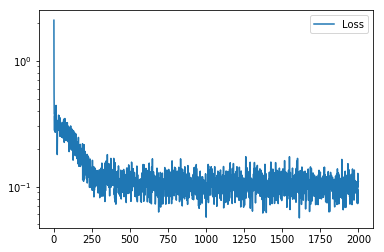

In [2]:
LRATE = 0.005
NODE   = 200
NLAYER = 5

DROPOUT = 0.0

EPOCHS = 2000
MONITOR = 100

REGU = 0.001

tf.reset_default_graph()

tf_x = tf.placeholder(tf.float32, shape=(N,1))
tf_y = tf.placeholder(tf.float32, shape=(N,1))
#tf_x = tf.placeholder(tf.float32, shape=x_train.shape)
#tf_y = tf.placeholder(tf.float32, shape=y_train.shape)
drop = tf.placeholder(tf.float32, shape=())
print (tf_x)

###
### Fully connected NN
###

regu = tf.contrib.layers.l2_regularizer(REGU)
args = { "kernel_initializer": tf.truncated_normal_initializer(), "bias_initializer": tf.zeros_initializer() }
args = { "kernel_initializer": None, "bias_initializer": None }
args = { "kernel_regularizer":regu, "bias_regularizer":regu }
actf = tf.nn.tanh
hidden = tf.layers.dense(tf_x, NODE, actf, **args)
hidden = tf.layers.dropout(hidden, rate=drop, training=True)
hidden = tf.layers.batch_normalization(hidden)
for i in range(NLAYER):
    hidden = tf.layers.dense(hidden, NODE, actf, **args)
    hidden = tf.layers.batch_normalization(hidden)
    hidden = tf.layers.dropout(hidden, rate=drop, training=True)
output = tf.layers.dense(hidden, 1, None)   ## no activation. Equal to "lambda x:x"
print (output)

###
### Lost function
###
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

if 0:
    print("=== Variables in tf.GraphKeys.REGULARIZATION_LOSSES :")
    for v in reg_losses:
        print (v)

loss_op = tf.losses.mean_squared_error(tf_y, output) + 0.01 * sum(reg_losses)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=LRATE)
#optimizer = tf.train.MomentumOptimizer(learning_rate=0.5, momentum=0.9)
#optimizer = tf.train.AdamOptimizer(learning_rate=LRATE)
#optimizer = tf.train.RMSPropOptimizer(learning_rate=LRATE, momentum=0.05)
train_op = optimizer.minimize(loss_op)

if 0:
    ### check all variables
    vars = 0
    for v in tf.all_variables():
        print (v)
        vars += np.prod(v.get_shape().as_list())
    print("Model size: ", vars, ' vars')


### training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    stat=[]
    for step in range(EPOCHS):
        x_train = np.linspace(-np.pi, np.pi,N).reshape(N,1)
        y_exact = np.sin(x_train+P)
        y_train = y_exact + np.random.normal(0, .3, size=y_exact.shape)

        _, l, pred = sess.run([train_op, loss_op, output], {tf_x: x_train, tf_y: y_train, drop:DROPOUT})
        stat.append([step, l])
        
        if step % MONITOR == 0:
            x_test = np.sort(np.random.uniform(-np.pi, np.pi, N)).reshape(N,1)
            y_test = np.sin(x_test+P)
            lt, y = sess.run([loss_op,output], {tf_x: x_test,tf_y: y_test, drop:0.0 } )
            #y = sess.run(output, {tf_x: x_test, drop:0.0 } )
            #lt=66
            if 1:  ## plot intermedia state
                plt.figure()
                plt.plot(x_train, y_exact)
                #plt.plot(x_train, pred, '.')
                plt.plot(x_test, y, '.')
                plt.title("Epoch: %d  Loss = %10.8f" % (step, lt) )
                plt.show()
                # Early stopping
                if ( lt < 1e-6): break


        step += 1
        
    stat = np.array(stat)
    plt.figure()
    plt.semilogy(stat[:,0], stat[:,1], label="Loss")
    plt.legend()
